In [1]:
pip install transformers accelerate bitsandbytes pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import torch
import os
from dotenv import load_dotenv 
from huggingface_hub import login

# --- Load ALL Configurations from .env file ---
# This single line reads your .env file and sets up ALL environment variables
# for this session (secrets, paths, etc.).
# It must be run BEFORE any library that needs these variables is used.
load_dotenv()
print("Environment variables from .env file loaded.")

# --- Hugging Face Login (No changes needed here) ---
# This code correctly reads the "HF_TOKEN" that was just loaded by load_dotenv()
try:
    hf_token = os.getenv("HF_TOKEN")
    if hf_token:
        login(token=hf_token)
        print("Successfully logged into Hugging Face.")
    else:
        print("Hugging Face token not found. Skipping login.")
except Exception as e:
    print(f"Could not log into Hugging Face: {e}")

# Now import libraries
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load model
model_name = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)


# Load Mistral-7B in 4-bit
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 3/3 [05:07<00:00, 102.65s/it]
Device set to use cuda:0


In [4]:
# === Load Personality Prompts ===
df_traits = pd.read_csv("personality_data_train.csv")
df_traits.columns = df_traits.columns.str.strip().str.lower()

In [6]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec━━━━━━━━━━━━━━━━━━  0/12 [multidict]
    Found existing installation: fsspec 2025.5.1  0/12 [multidict]
    Uninstalling fsspec-2025.5.1:━━━━━━━━━━━  0/12 [multidict]
      Successfully uninstalled fsspec-2025.5.10m  0/12 [multidict]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [datasets]/12 [datasets]]ss]lls]


In [63]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import difflib

# === Load MMLU Subset ===
from datasets import load_dataset

subjects = [
    "abstract_algebra",
    "college_physics",
    "high_school_us_history",
    "high_school_psychology",
    "logical_fallacies",
    "professional_law",
    "moral_scenarios"
]

In [64]:
# === MODIFIED FUNCTION: generate_output ===
def generate_output(prompt):
    """
    This function now uses the generator pipeline directly.
    It returns only the new text, which solves the prompt repetition problem.
    """
    # <<< FIX #1: Using the generator with return_full_text=False >>>
    out = generator(
        prompt,
        max_new_tokens=10,  # Reduced token limit, as we expect a very short answer
        do_sample=False,
        return_full_text=False
    )
    # The output is already clean, containing only the generated text
    return out[0]['generated_text']

In [68]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import re

# === Format Prompt ===
def format_mmlu_prompt(question, choices, personality_prompt=None):
    choice_str = "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)])
    prompt = f"{question}\n{choice_str}\n"
    if personality_prompt:
        prompt += (
            f"\nBased on your personality: \"{personality_prompt.strip()}\"\n"
            "Which option (A, B, C, or D) is correct? Answer with only the letter."
        )
    else:
        prompt += "\nWhich option (A, B, C, or D) is correct? Answer with only the letter."
    return prompt

def extract_letter(text):
    match = re.search(r"\b([A-D])\b", text.upper())
    return match.group(1) if match else "?"

# === Evaluate One Subject ===
def evaluate_subject(subject, n_samples=100):
    print(f"\n=== Running MMLU Subject: {subject} ===")
    mmlu = load_dataset("cais/mmlu", subject, split="test").select(range(n_samples))
    results = []

    # Neutral
    for ex in mmlu:
        prompt = format_mmlu_prompt(ex['question'], ex['choices'])
        out = generator(prompt, max_new_tokens=60, do_sample=False)[0]['generated_text']
        #print(f"[neutral] {ex['question'][:60]}... → {out.strip()[:60]}")
        results.append({
            "subject": subject,
            "trait": "neutral",
            "question": ex["question"],
            "choices": ex["choices"],
            "answer": ex["answer"],
            "model_output": out,
            "model_choice": extract_letter(out)
        })

    # With Traits
    for _, row in df_traits.iterrows():
        trait = row["target personality"]
        personality_prompt = row["answer"]

        for ex in mmlu:
            prompt = format_mmlu_prompt(ex['question'], ex['choices'], personality_prompt)
            out = generator(prompt, max_new_tokens=60, do_sample=False)[0]['generated_text']
            #print(f"[{trait}] {ex['question'][:60]}... → {out.strip()[:60]}")
            results.append({
                "subject": subject,
                "trait": trait,
                "question": ex["question"],
                "choices": ex["choices"],
                "answer": ex["answer"],
                "model_output": out,
                "model_choice": extract_letter(out)
            })

    return pd.DataFrame(results)


In [66]:
# === Score MMLU Outputs ===
# === Score Results ===
def score_results(df):
    def letter_to_index(letter):
        return {"A": 0, "B": 1, "C": 2, "D": 3}.get(letter, -1)

    df["model_index"] = df["model_choice"].apply(letter_to_index)
    df["correct"] = df["model_index"] == df["answer"]

    summary = df.groupby(["subject", "trait"])["correct"].agg(["count", "sum", "mean"]).reset_index()
    summary.columns = ["subject", "trait", "n_total", "n_correct", "accuracy"]

    # Add neutral accuracy diffs
    def add_diff(group):
        if "neutral" in group["trait"].values:
            neutral_acc = group.loc[group["trait"] == "neutral", "accuracy"].values[0]
            group["accuracy_diff"] = group["accuracy"] - neutral_acc
        else:
            group["accuracy_diff"] = None
        return group

    summary = summary.groupby("subject").apply(add_diff).reset_index(drop=True)
    return df, summary


=== Running MMLU Subject: abstract_algebra ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: college_physics ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: high_school_us_history ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: high_school_psychology ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: logical_fallacies ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: professional_law ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge


=== Running MMLU Subject: moral_scenarios ===


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:2 for open-end ge

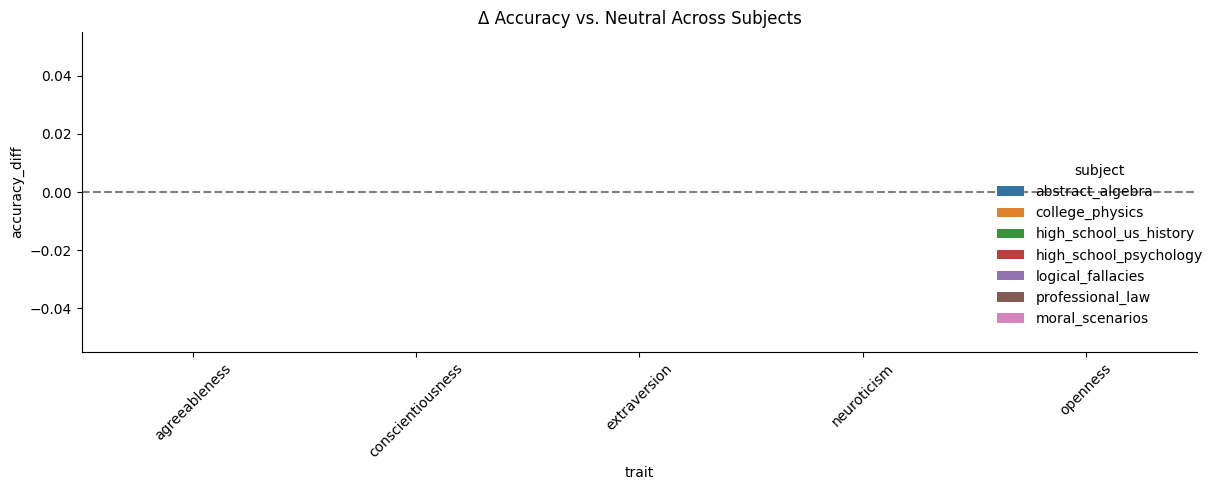

In [69]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import re

# === Run Full Multi-Subject Experiment ===
all_results = []
all_summaries = []

for subj in subjects:
    df_subj = evaluate_subject(subj, n_samples=20)  # use 20 for quick testing
    df_subj, summary = score_results(df_subj)
    all_results.append(df_subj)
    all_summaries.append(summary)

df_all = pd.concat(all_results, ignore_index=True)
df_summary = pd.concat(all_summaries, ignore_index=True)

# === Save to CSV ===
df_all.to_csv("exp2_mmlu_detailed.csv", index=False)
df_summary.to_csv("exp2_mmlu_summary.csv", index=False)

# === Plotting (Optional) ===
sns.catplot(data=df_summary[df_summary["trait"] != "neutral"],
            x="trait", y="accuracy_diff", hue="subject",
            kind="bar", height=5, aspect=2)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Δ Accuracy vs. Neutral Across Subjects")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [74]:
print(df_summary)

                   subject              trait  n_total  n_correct  accuracy  \
0         abstract_algebra      agreeableness      120         24      0.20   
1         abstract_algebra  conscientiousness      120         24      0.20   
2         abstract_algebra       extraversion      120         24      0.20   
3         abstract_algebra        neuroticism      120         24      0.20   
4         abstract_algebra            neutral       20          4      0.20   
5         abstract_algebra           openness      120         24      0.20   
6          college_physics      agreeableness      120         36      0.30   
7          college_physics  conscientiousness      120         36      0.30   
8          college_physics       extraversion      120         36      0.30   
9          college_physics        neuroticism      120         36      0.30   
10         college_physics            neutral       20          6      0.30   
11         college_physics           openness      1

In [71]:
df_all.groupby("trait")["model_output"].apply(lambda x: x.nunique()).sort_values()


trait
neutral              139
agreeableness        834
extraversion         834
conscientiousness    834
neuroticism          834
openness             834
Name: model_output, dtype: int64

ValueError: Could not interpret value `accuracy_diff` for `y`. An entry with this name does not appear in `data`.